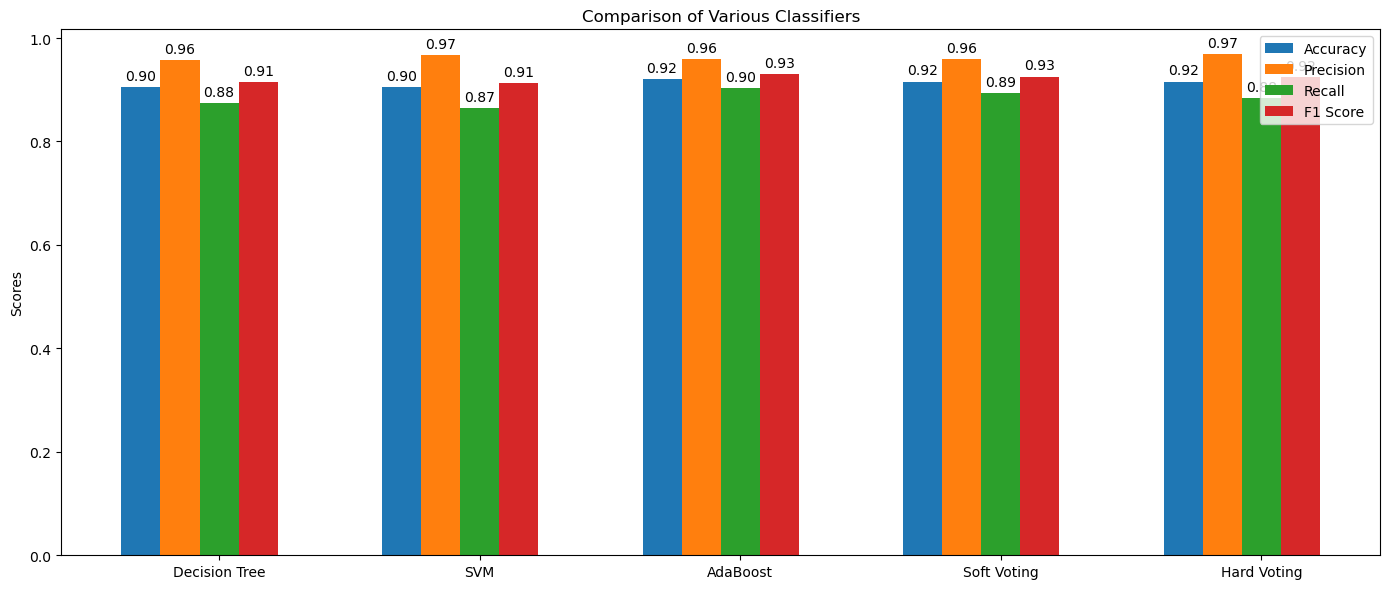

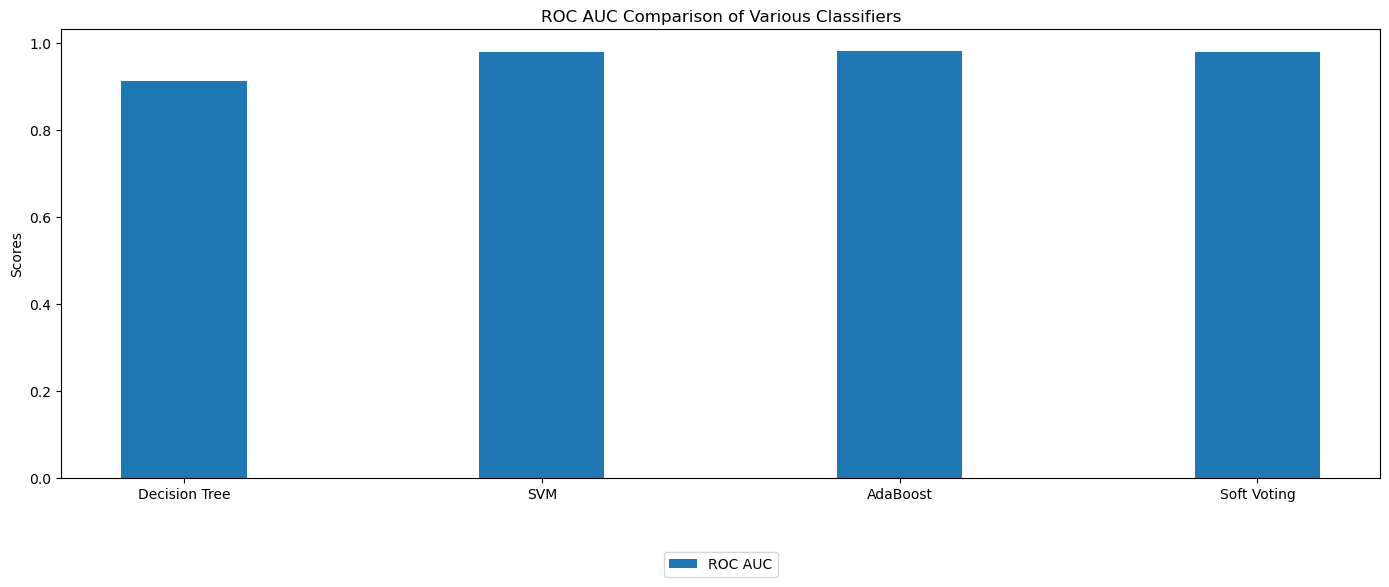

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the dataset
file_path = 'dataset.csv'
data = pd.read_csv(file_path)

# Separate features and target label
X = data.drop(columns='label')
y = data['label']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define classifiers
dt_classifier = DecisionTreeClassifier(random_state=42)
svm_classifier = SVC(kernel='rbf', gamma='auto', probability=True, random_state=42)
ada_classifier = AdaBoostClassifier(random_state=42)

# Define the voting classifiers
soft_voting_classifier = VotingClassifier(estimators=[
    ('svm', svm_classifier),
    ('decision_tree', dt_classifier),
    ('ada_boost', ada_classifier)
], voting='soft')

hard_voting_classifier = VotingClassifier(estimators=[
    ('svm', svm_classifier),
    ('decision_tree', dt_classifier),
    ('ada_boost', ada_classifier)
], voting='hard')

# Train the classifiers
dt_classifier.fit(X_train, y_train)
svm_classifier.fit(X_train, y_train)
ada_classifier.fit(X_train, y_train)
soft_voting_classifier.fit(X_train, y_train)
hard_voting_classifier.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_classifier.predict(X_test)
y_pred_svm = svm_classifier.predict(X_test)
y_pred_ada = ada_classifier.predict(X_test)
y_pred_soft_voting = soft_voting_classifier.predict(X_test)
y_pred_hard_voting = hard_voting_classifier.predict(X_test)

# Probability estimates for ROC AUC
dt_probs = dt_classifier.predict_proba(X_test)[:, 1]
svm_probs = svm_classifier.predict_proba(X_test)[:, 1]
ada_probs = ada_classifier.predict_proba(X_test)[:, 1]
soft_voting_probs = soft_voting_classifier.predict_proba(X_test)[:, 1]

# Evaluate metrics
classifiers = {
    'Decision Tree': (y_pred_dt, dt_probs),
    'SVM': (y_pred_svm, svm_probs),
    'AdaBoost': (y_pred_ada, ada_probs),
    'Soft Voting': (y_pred_soft_voting, soft_voting_probs),
    'Hard Voting': (y_pred_hard_voting, None)  # No probs for hard voting
}

metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
roc_auc_metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']

results = {metric: [] for metric in roc_auc_metrics}

for name, (y_pred, probs) in classifiers.items():
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['Precision'].append(precision_score(y_test, y_pred))
    results['Recall'].append(recall_score(y_test, y_pred))
    results['F1 Score'].append(f1_score(y_test, y_pred))
    if probs is not None:
        results['ROC AUC'].append(roc_auc_score(y_test, probs))
    else:
        results['ROC AUC'].append(None)

# Filter out None values from ROC AUC results
roc_auc_values = [results['ROC AUC'][i] for i in range(len(results['ROC AUC'])) if results['ROC AUC'][i] is not None]
roc_auc_labels = [list(classifiers.keys())[i] for i in range(len(results['ROC AUC'])) if results['ROC AUC'][i] is not None]

# Plotting bar graph for comparison
x = np.arange(len(classifiers))
width = 0.15

fig, ax = plt.subplots(figsize=(14, 6))

rects = []
offset = -width * 2  # Center the bars around the x-ticks
for idx, metric in enumerate(metrics):
    values = [results[metric][i] for i in range(len(results[metric]))]
    rects.append(ax.bar(x + offset, values, width, label=metric))
    offset += width

ax.set_ylabel('Scores')
ax.set_title('Comparison of Various Classifiers')
ax.set_xticks(x)
ax.set_xticklabels(classifiers.keys())
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        if height is not None:
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

for rect in rects:
    autolabel(rect)

fig.tight_layout()
plt.show()

# Plotting bar graph for ROC AUC comparison (excluding Hard Voting)
roc_auc_x = np.arange(len(roc_auc_labels))
roc_auc_width = 0.35

roc_auc_fig, roc_auc_ax = plt.subplots(figsize=(14, 6))

roc_auc_rects = roc_auc_ax.bar(roc_auc_x, roc_auc_values, roc_auc_width, label='ROC AUC')

roc_auc_ax.set_ylabel('Scores')
roc_auc_ax.set_title('ROC AUC Comparison of Various Classifiers')
roc_auc_ax.set_xticks(roc_auc_x)
roc_auc_ax.set_xticklabels(roc_auc_labels)
roc_auc_ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

autolabel(roc_auc_rects)

roc_auc_fig.tight_layout()
plt.show()
